<a href="https://colab.research.google.com/github/kbpotts1/Trisomy_NeuralNetwork/blob/master/K_Potts_Thinkful_Final_Capstone_Project_v2_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kevin Potts
# Final Capstone: Using Neural networks to predict Down Syndrome-associated learning deficits.

In [0]:
import tensorflow as tf

In [3]:
import keras

Using TensorFlow backend.


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras.layers import Conv1D, MaxPooling1D, Flatten


In [5]:
from google.colab import files

upload = files.upload()



Saving Data_Cortex_Nuclear .csv to Data_Cortex_Nuclear .csv


In [0]:
df = pd.read_csv('Data_Cortex_Nuclear .csv')

In [0]:
#Impute missing protein expression values with a random value chosen from a normal distribution centered on the protein's mean
#expression value

for c in range(1, (len(df.columns.values))-4):
    df.iloc[:, c].fillna(np.random.normal(np.mean(df.iloc[:, c]), np.std(df.iloc[:, c])), inplace = True)

In [0]:
#Change outcome variables to numeric

df.Genotype.replace({'Control': 0, 'Ts65Dn': 1}, inplace = True)
df.Treatment.replace({'Memantine': 1, 'Saline': 0}, inplace = True)
df.Behavior.replace({'C/S': 0, 'S/C': 1}, inplace = True)
df['class'].replace({'c-CS-m': 0, 'c-SC-m': 1, 'c-CS-s': 2, 'c-SC-s': 3, 't-CS-m': 4, 't-SC-m': 5, 't-CS-s': 6, 't-SC-s': 7}, inplace = True)

In [9]:
df = df.drop(columns = ['MouseID'], axis = 1)
df.head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,0,1,0,0
1,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,0,1,0,0
2,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,0,1,0,0
3,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,0,1,0,0
4,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,0,1,0,0


In [0]:
#Create train and test sets for each outcome variable (genotype, learning state, and presence of memantine), as well as for the 'class' variable

xtrains = []
xtests = []
ytrains = []
ytests = []

for y in range(-4,0):
    X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-4],df.iloc[:, y], test_size=0.40, random_state=42)
    y_train = keras.utils.to_categorical(y_train, len(np.unique(y_train)))
    y_test = keras.utils.to_categorical(y_test, len(np.unique(y_test)))
    xtrains.append(X_train)
    xtests.append(X_test)
    ytrains.append(y_train)
    ytests.append(y_test)

Next I will create a general utility sequential neural network. The network will consist of 4 layers (2 hidden) with 30% dropout following each layer. Activation function for each layer but the output is set for ReLu (the output layer activation function is sigmoid). 

In [0]:
#Define a sequential neural network function

def gene_exp_network(X_train, y_train, X_test, y_test):
  
  models = []
  
  model = Sequential()
  model.add(Dense(64, activation = 'relu', input_shape = (X_train.shape[1],)))
  model.add(Dropout(0.3))
  model.add(Dense(32, activation = 'relu'))
  model.add(Dropout(0.3))
  model.add(Dense(10, activation = 'relu'))

  model.add(Dense(y_test.shape[1], activation = 'sigmoid'))

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  
  models.append(model)

  history = model.fit(X_train, y_train,
                    batch_size= 50,
                    epochs=100,
                    verbose=False,
                    validation_data=(X_test, y_test))
  score = model.evaluate(X_test, y_test, verbose=0)
  loss = score[0]
  accuracy = score[1]
  return history, loss, accuracy

Here I will see how well this NN model predicts genotype, learning, and memantine injection as a function of gene expression values

In [12]:
results = []

for i in range(4):
  network = gene_exp_network(xtrains[i], ytrains[i], xtests[i], ytests[i])
  results.append(network)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [13]:
print('genotype loss: {}'.format(results[0][1]))
print('genotype accuracy: {}\n'.format(results[0][2]))

print('treatment loss: {}'.format(results[1][1]))
print('treatment accuracy: {}\n'.format(results[1][2]))

print('behavior loss: {}'.format(results[2][1]))
print('behavior accuracy: {}\n'.format(results[2][2]))

print('class loss: {}'.format(results[3][1]))
print('class accuracy: {}'.format(results[3][2]))
      

genotype loss: 0.08569123789116188
genotype accuracy: 0.9837962962962963

treatment loss: 0.21051045479597869
treatment accuracy: 0.9340277777777778

behavior loss: 0.013736597059674008
behavior accuracy: 0.9953703703703703

class loss: 0.2002694441212548
class accuracy: 0.9085648148148148


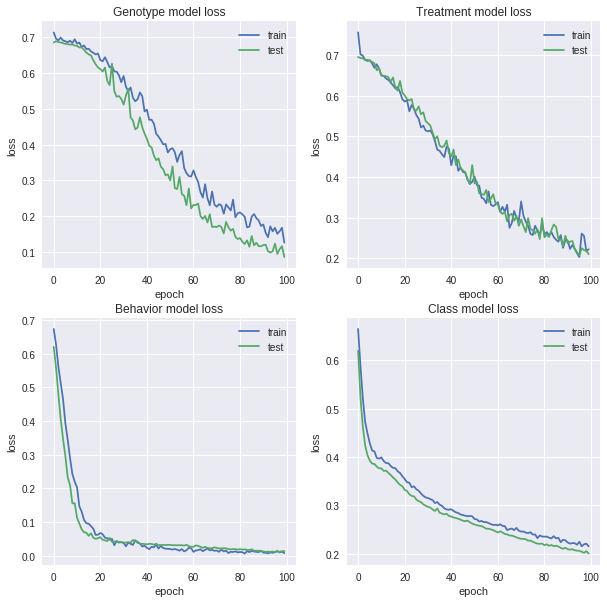

In [14]:
#Plot loss functions vs. epoch

plt.figure(figsize = (10,10))


#Genotype results

plt.subplot(2,2,1)
plt.plot(results[0][0].history['loss'])
plt.plot(results[0][0].history['val_loss'])
plt.title('Genotype model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])

#Treatment results

plt.subplot(2,2,2)
plt.plot(results[1][0].history['loss'])
plt.plot(results[1][0].history['val_loss'])
plt.title('Treatment model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])

#Behavior results

plt.subplot(2,2,3)
plt.plot(results[2][0].history['loss'])
plt.plot(results[2][0].history['val_loss'])
plt.title('Behavior model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])

#Class results

plt.subplot(2,2,4)
plt.plot(results[3][0].history['loss'])
plt.plot(results[3][0].history['val_loss'])
plt.title('Class model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])


plt.show()


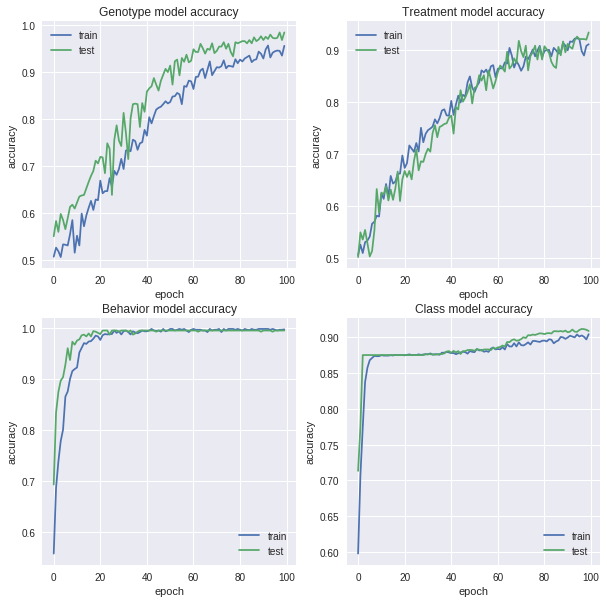

In [15]:
plt.figure(figsize = (10,10))

#Genotype
plt.subplot(2,2,1)
plt.plot(results[0][0].history['acc'])
plt.plot(results[0][0].history['val_acc'])
plt.title('Genotype model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])

#Treatment
plt.subplot(2,2,2)
plt.plot(results[1][0].history['acc'])
plt.plot(results[1][0].history['val_acc'])
plt.title('Treatment model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])

#Behavior
plt.subplot(2,2,3)
plt.plot(results[2][0].history['acc'])
plt.plot(results[2][0].history['val_acc'])
plt.title('Behavior model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])


#Class
plt.subplot(2,2,4)
plt.plot(results[3][0].history['acc'])
plt.plot(results[3][0].history['val_acc'])
plt.title('Class model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])

plt.show()

Next I will use an autoencoder function to attempt to remove 'noise' from the protein expression data. I will then run the autoencoded data through a supervised learning model (a ridge classifier) to compare this classification technique with the neural network constructed above.

In [0]:
#Define an autoencoder function with up to 4 hidden layers     
      
def autoencoder_transform(X_train, X_test, n_hidden):
  
  input_dim = X_train.shape[1]
  input_layer = Input(shape=(input_dim, ))
  
  hidden_1 = Dense(input_dim, activation='relu')(input_layer)
  hidden_2 = Dense(input_dim, activation = 'relu')(hidden_1)
  hidden_3 = Dense(input_dim, activation = 'relu')(hidden_2)
  hidden_4 = Dense(input_dim, activation = 'relu')(hidden_3)
 
  if n_hidden == 1:    
    output_layer = output_layer = Dense(input_dim, activation = 'sigmoid')(hidden_1)
  elif n_hidden == 2:
    output_layer = Dense(input_dim, activation = 'sigmoid')(hidden_2)
  elif n_hidden == 3:
    output_layer = Dense(input_dim, activation = 'sigmoid')(hidden_3)
  elif n_hidden == 4:
    output_layer = Dense(input_dim, activation = 'sigmoid')(hidden_4)
      
  autoencoder = Model(inputs=input_layer, outputs=output_layer)
    
  autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
      
  
  history = autoencoder.fit(X_train, X_train, validation_data = (X_test, X_test), epochs = 100, verbose = False).history
  transformed = autoencoder.predict(X_test)
  
  return history, transformed


In [0]:
#Autoencode the X_test data from the gene expression dataset using an autoencoder with 4 hidden layers

xtrains = []
xtests = []
ytrains = []
ytests = []

for y in range(-4,0):
    X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:-4],df.iloc[:, y], test_size=0.40, random_state=42)
    xtrains.append(X_train)
    xtests.append(X_test)
    ytrains.append(y_train)
    ytests.append(y_test)
    
history_deep, transformed_deep = autoencoder_transform(xtrains[0], xtests[0], n_hidden = 4)

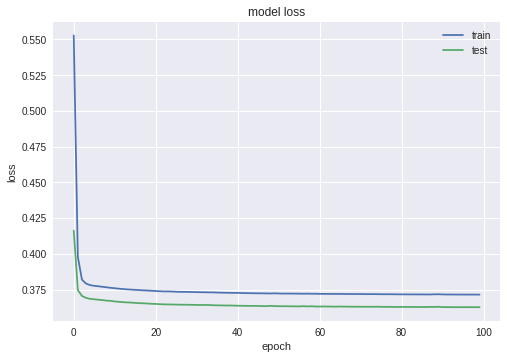

In [18]:
#Look to see how much was lost in autoencoding the data


plt.plot(history_deep['loss'])
plt.plot(history_deep['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [0]:
#Run the autoencoded X_test values through a ridge classifier to predict genotype, drug treatment, learning, and class

from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score

deep_autoencoder_accuracy = []

for i in range(0,4):
  rc = RidgeClassifier(alpha = 5)
  rc.fit(transformed_deep,ytests[i])
  deep_autoencoder_accuracy.append(accuracy_score(ytests[i], rc.predict(transformed_deep)))

In [20]:
#How well does the autoencoded data predict 1) genotype, 2) treatment type (memantine vs. saline), 3) learning condition, 4) class

print('Deep autoencoder: \n Genotype: {}, Treatment: {}, Learning: {}, Class: {}'.format(deep_autoencoder_accuracy[0], deep_autoencoder_accuracy[1], deep_autoencoder_accuracy[2],deep_autoencoder_accuracy[3]))



Deep autoencoder: 
 Genotype: 0.7337962962962963, Treatment: 0.6944444444444444, Learning: 0.9930555555555556, Class: 0.5949074074074074


It looks as though autoencoding the data may have resulted in the loss of information that was necessary for predicting the outcome variables (i.e. the autoencoder model perceived important information as 'noise'). In the analyses below I will use the sequential neural network function, which had a predictive ability far superior to the autoencoder/ridge function.


Each of these analyses will attempt to train the model to predict a particular biologically relevant component of the outcome set.

*Question #1: Can we predict the gene expression-level effect of trisomy, after controlling for other variables? (i.e., class t-SC-s vs. c-SC-s)*

In [0]:
#Can the model predict the effect of trisomy after controlling for the other variables?

df_t = pd.concat([df[df['class'] == 7], df[df['class'] == 3]])
df_t = df_t.drop(columns = ['Genotype', 'Behavior', 'Treatment'])


In [0]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(df_t.iloc[:, :-1],df_t.iloc[:, -1], test_size=0.40, random_state=42)
y_train_t = keras.utils.to_categorical(y_train_t)
y_test_t = keras.utils.to_categorical(y_test_t)

In [0]:

model = Sequential()
model.add(Dense(64, activation = 'relu', input_shape = (77,)))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))

model.add(Dense(np.shape(y_train_t)[1], activation = 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_t, y_train_t,
                    epochs=100,
                    verbose=False,
                    validation_data=(X_test_t, y_test_t))
score = model.evaluate(X_test_t, y_test_t, verbose=0)
loss = score[0]
accuracy = score[1]


In [24]:
print(loss)
print(accuracy)

0.027708413286341563
0.9884259281335054


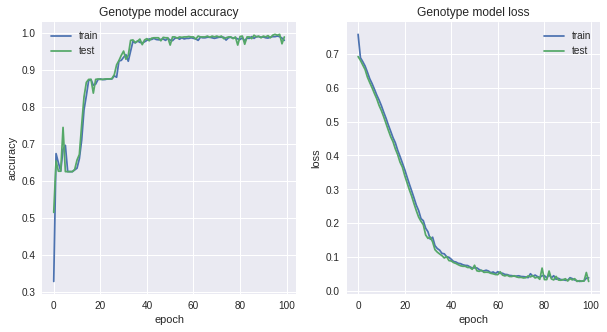

In [25]:
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Genotype model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Genotype model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])

plt.show()

*Question #2: Can we predict the gene expression-level influence of memantine (to rescue learning ability) in trisomic mice (i.e., class t-CS-m vs. t-CS-s)?*

In [0]:
#Can the model distinguish between trisomic mice injected with memantine (to rescue their learning ability) vs.
#those whose learning abilities remained impaired?

df_m = pd.concat([df[df['class'] == 4], df[df['class'] == 6]])
df_m = df_m.drop(columns = ['Genotype', 'Behavior', 'Treatment'])


In [0]:
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(df_m.iloc[:, :-1],df_m.iloc[:, -1], test_size=0.40, random_state=42)
y_train_m = keras.utils.to_categorical(y_train_m)
y_test_m = keras.utils.to_categorical(y_test_m)

In [0]:
model = Sequential()
model.add(Dense(64, activation = 'relu', input_shape = (77,)))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))

model.add(Dense(np.shape(y_train_m)[1], activation = 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_m, y_train_m,
                    epochs=100,
                    verbose=False,
                    validation_data=(X_test_m, y_test_m))
score = model.evaluate(X_test_m, y_test_m, verbose=0)
loss = score[0]
accuracy = score[1]

In [29]:
print(loss)
print(accuracy)

0.0600042479733626
0.9776785969734192


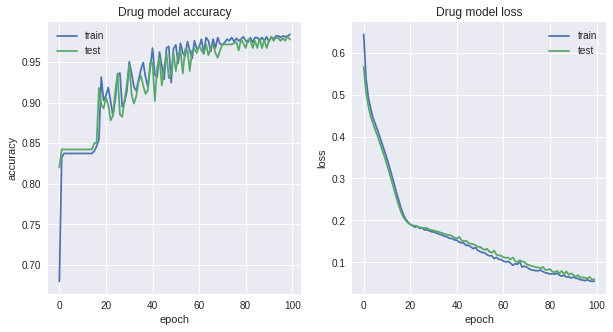

In [30]:
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Drug model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Drug model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])

plt.show()

*Question #3: Can we predict the gene expression-level effects of context-fear conditioning-based learning in trisomic mice injected with memantine (to rescue their learning ability) (i.e., class t-CS-m vs. t-SC-m)?*

In [0]:
#Can this model classify trisomic mice injected with memantine who have been exposed to 
#learning vs. those who have not been exposed? (i.e., can the model distinguish the effects
#context fear-conditioning training in trisomic mice with rescued learning ability (t-CS-m vs. t-SC-m)?)

df_l = pd.concat([df[df['class'] == 4], df[df['class'] == 5]])
df_l = df_l.drop(columns = ['Genotype', 'Behavior', 'Treatment'])


In [0]:
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(df_l.iloc[:, :-1],df_l.iloc[:, -1], test_size=0.40, random_state=42)
y_train_l = keras.utils.to_categorical(y_train_l)
y_test_l = keras.utils.to_categorical(y_test_l)

In [0]:
model = Sequential()
model.add(Dense(64, activation = 'relu', input_shape = (77,)))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))

model.add(Dense(np.shape(y_train_l)[1], activation = 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_l, y_train_l,
                    epochs=100,
                    verbose=False,
                    validation_data=(X_test_l, y_test_l))
score = model.evaluate(X_test_l, y_test_l, verbose=0)
loss = score[0]
accuracy = score[1]

In [34]:
print(loss)
print(accuracy)

0.0003770604057030545
1.0


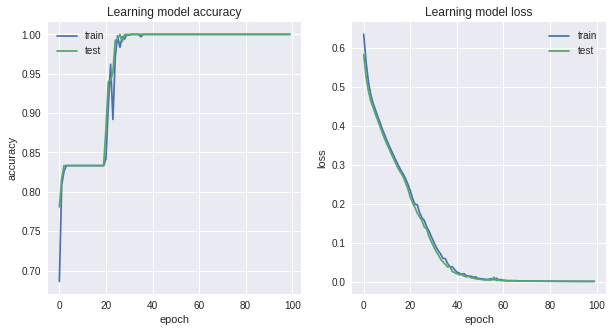

In [35]:
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Learning model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])

plt.show()

*Question #4: Can we predict the influence of context-fear conditioning-based learning on trisomic individuals that have NOT had their learning ability rescued via memantine? (i.e., t-SC-s vs. t-CS-s)*

In [0]:
#Can the model predict the effect of context fear-conditioning in trisomic mice when subjects have NOT been injected
#with memantine (i.e., learning has not been rescued)?

df_nl = pd.concat([df[df['class'] == 6], df[df['class'] == 7]])
df_nl = df_nl.drop(columns = ['Genotype', 'Behavior', 'Treatment'])

In [0]:
X_train_nl, X_test_nl, y_train_nl, y_test_nl = train_test_split(df_nl.iloc[:, :-1],df_nl.iloc[:, -1], test_size=0.40, random_state=42)
y_train_nl = keras.utils.to_categorical(y_train_nl)
y_test_nl = keras.utils.to_categorical(y_test_nl)

In [0]:
model = Sequential()
model.add(Dense(64, activation = 'relu', input_shape = (77,)))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))

model.add(Dense(np.shape(y_train_nl)[1], activation = 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_nl, y_train_nl,
                    epochs=100,
                    verbose=False,
                    validation_data=(X_test_nl, y_test_nl))
score = model.evaluate(X_test_nl, y_test_nl, verbose=0)
loss = score[0]
accuracy = score[1]

In [39]:
print(loss)
print(accuracy)

0.003224045659104983
1.0


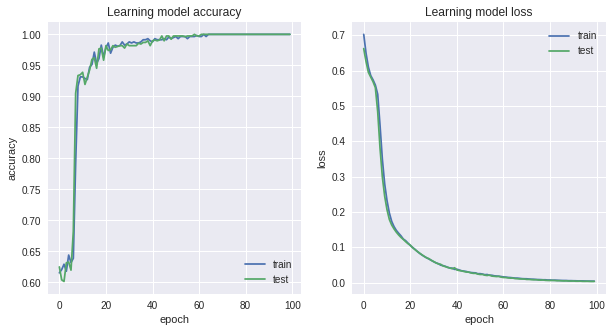

In [40]:
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Learning model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])

plt.show()

Finally I will examine potential overfitting to the "behavior/learning" outcome by performing cross-validation on that outcome variable using logistic regression models

In [43]:
#Any classifier trained to classify CS vs. SC seems to completely overfit the data. I'll examine this by training 
#a logistic regression model to predict the 'behavior' variable, and validate it using cross-validation scoring.

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score


lr = LogisticRegression()
cv = cross_val_score(lr, df.iloc[:, :-4], df.iloc[:, -2], cv = 10)
print(cv)
print(np.mean(cv))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

[1.         0.96330275 1.         1.         1.         1.
 1.         1.         0.94392523 1.        ]
0.9907227985938437


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


While not every fold included in the cross-validation test above produces a score of 1.0, most scores are either 1.0 or close to it. These results are robust to the model used in the cv test (other models not shown here). This suggests that the ability of the NNs above to nearly perfectly predict the 'behavior/learning' outcome is a real phenomenon - this is, perhaps, telling us that context-fear conditioning has such distinct effects on gene expression in these particular genes that its effects are easily predictable, regardless of which model is applied.